In [1]:
import os
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm

import sounddevice as sd

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cpu


In [2]:
BASE = r"C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT"
TRAIN_AUDIO_DIR = os.path.join(BASE, r"depression_detection\data\train")
TEST_AUDIO_DIR = os.path.join(BASE, r"depression_detection\data\test")
TRAIN_CSV = os.path.join(BASE, r"train_split_Depression_AVEC2017.csv")
TEST_CSV = os.path.join(BASE, r"test_split_Depression_AVEC2017.csv")
FEATURE_DIR = os.path.join(BASE, r"depression_detection\features")
MODEL_DIR = os.path.join(BASE, r"depression_detection\models")
CODE_DIR = os.path.join(BASE, r"CODES\code")

os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(CODE_DIR, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

SR = 16000
WINDOW_SEC = 5
HOP_SEC = 2.5
NMELS = 64
NFFT = 1024
HOPLEN = 256

BATCH_SIZE = 16
EPOCHS = 15
PATIENCE = 6


In [3]:
def extract_log_mel(y, sr=SR, nmels=NMELS, nfft=NFFT, hoplength=HOPLEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=nfft, hop_length=hoplength, n_mels=nmels, power=2.0)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    return log_mel.astype(np.float32)

def process_file_to_windows(wav_path, out_dir, window_sec=WINDOW_SEC, hop_sec=HOP_SEC, sr=SR):
    y, _ = librosa.load(wav_path, sr=sr)
    total = len(y)
    window_samples = int(window_sec * sr)
    hop_samples = int(hop_sec * sr)
    starts = list(range(0, max(1, total - window_samples + 1), hop_samples))
    if starts and (starts[-1] + window_samples < total):
        starts.append(total - window_samples)
    if not starts:
        starts = [0]
    saved = []
    for i, s in enumerate(starts):
        chunk = y[s:s+window_samples]
        mel = extract_log_mel(chunk, sr=sr)
        base = Path(wav_path).stem
        fname = f"{base}_win{i}.npy"
        out_path = os.path.join(out_dir, fname)
        np.save(out_path, mel)
        saved.append(out_path)
    return saved


In [4]:
def preprocess_all_train(train_csv=TRAIN_CSV, audio_dir=TRAIN_AUDIO_DIR, feature_dir=FEATURE_DIR):
    df = pd.read_csv(train_csv)
    mapping = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Preprocess train"):
        pid = str(int(row['Participant_ID']))
        wav_name = f"{pid}_AUDIO.wav"
        wav_path = os.path.join(audio_dir, wav_name)
        if not os.path.exists(wav_path):
            print("Missing:", wav_path)
            continue
        saved = process_file_to_windows(wav_path, feature_dir)
        for p in saved:
            mapping.append({"file": p, "participant": pid, "label": int(row["PHQ8_Binary"])})
    with open(os.path.join(feature_dir, "mapping.json"), "w") as f:
        json.dump(mapping, f)
    print("Total windows saved:", len(mapping))
    return mapping

mapping_path = os.path.join(FEATURE_DIR, "mapping.json")
if not os.path.exists(mapping_path):
    mapping = preprocess_all_train()
else:
    print("Mapping exists:", mapping_path)
    with open(mapping_path, "r") as f:
        mapping = json.load(f)

print("Total windows:", len(mapping))
from collections import Counter
cnt = Counter([m["participant"] for m in mapping])
print("Example windows per participant (first 8):", list(cnt.items())[:8])


Mapping exists: C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\features\mapping.json
Total windows: 38682
Example windows per participant (first 8): [('303', 394), ('304', 317), ('305', 681), ('310', 337), ('312', 315), ('313', 301), ('315', 390), ('316', 347)]


In [5]:
class WindowDataset(Dataset):
    def __init__(self, mapping, max_frames=None):
        self.mapping = mapping
        self.max_frames = max_frames or self._compute_max_frames()
    def _compute_max_frames(self):
        maxf = 0
        for entry in self.mapping:
            arr = np.load(entry["file"])
            maxf = max(maxf, arr.shape[1])
        return maxf
    def __len__(self):
        return len(self.mapping)
    def __getitem__(self, idx):
        entry = self.mapping[idx]
        arr = np.load(entry["file"])
        n_mels, frames = arr.shape
        mf = self.max_frames
        if frames < mf:
            arr = np.pad(arr, ((0,0),(0,mf-frames)), mode='constant')
        elif frames > mf:
            arr = arr[:, :mf]
        x = torch.tensor(arr, dtype=torch.float).unsqueeze(0)
        y = torch.tensor(entry["label"], dtype=torch.float)
        return x, y

dataset = WindowDataset(mapping)
print("Dataset windows:", len(dataset), "max_frames:", dataset.max_frames)

df_map = pd.DataFrame(mapping)
participants = df_map['participant'].unique()
part_labels = df_map.groupby('participant')['label'].first().astype(int)
train_parts, val_parts = train_test_split(participants, test_size=0.2, random_state=SEED, 
                                          stratify=[part_labels.get(p,0) for p in participants])

train_idx = df_map[df_map['participant'].isin(train_parts)].index.tolist()
val_idx = df_map[df_map['participant'].isin(val_parts)].index.tolist()

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train windows:", len(train_ds), "Val windows:", len(val_ds))


Dataset windows: 38682 max_frames: 313
Train windows: 30789 Val windows: 7893


In [6]:
class RNNEncoder(nn.Module):
    def __init__(self, in_dim=NMELS, hidden_dim=128, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(in_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
    def forward(self, x):
        # x shape: (B,1,n_mels, frames)
        x = x.squeeze(1)  # (B, n_mels, frames)
        x = x.permute(0, 2, 1)  # (B, frames, n_mels)
        out, _ = self.rnn(x)
        return out

class RNNBiLSTM(nn.Module):
    def __init__(self, nmels=NMELS, lstm_hidden=128):
        super().__init__()
        self.encoder = RNNEncoder(nmels)
        self.lstm_hidden = lstm_hidden
        self.lstm = None
        self.classifier = nn.Sequential(
            nn.Linear(2*lstm_hidden, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        b, c, h, w = x.shape
        feat = self.encoder(x)
        if self.lstm is None:
            input_size = feat.shape[-1]
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.lstm_hidden, num_layers=1,
                                batch_first=True, bidirectional=True).to(x.device)
        out, _ = self.lstm(feat)
        out = out[:, -1, :]
        logits = self.classifier(out).squeeze(1)
        return logits

model = RNNBiLSTM().to(DEVICE)
print(model)


RNNBiLSTM(
  (encoder): RNNEncoder(
    (rnn): RNN(64, 128, batch_first=True, bidirectional=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [7]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

best_val = float('inf')
pat = 0
for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}", flush=True)
    model.train()
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, desc=f"Train E{epoch}"):
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend(probs.tolist())
            trues.extend(yb.cpu().numpy().tolist())

    val_loss /= len(val_loader.dataset)
    val_pred = [1 if p > 0.5 else 0 for p in preds]
    val_acc = accuracy_score(trues, val_pred)
    val_f1 = f1_score(trues, val_pred, zero_division=0)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        pat = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "best_rnn_bilstm.pth"))
        print("Saved best model.")
    else:
        pat += 1
        if pat >= PATIENCE:
            print("Early stopping")
            break

print("Training completed.")



Epoch 1/15


Train E1:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5931 val_loss=0.6015 acc=0.7083 f1=0.0000
Saved best model.

Epoch 2/15


Train E2:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5904 val_loss=0.5990 acc=0.7083 f1=0.0000
Saved best model.

Epoch 3/15


Train E3:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5900 val_loss=0.5986 acc=0.7083 f1=0.0000
Saved best model.

Epoch 4/15


Train E4:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 4: train_loss=0.5884 val_loss=0.6005 acc=0.7083 f1=0.0000

Epoch 5/15


Train E5:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 5: train_loss=0.5869 val_loss=0.5963 acc=0.7083 f1=0.0000
Saved best model.

Epoch 6/15


Train E6:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 6: train_loss=0.5865 val_loss=0.5964 acc=0.7083 f1=0.0000

Epoch 7/15


Train E7:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 7: train_loss=0.5860 val_loss=0.5948 acc=0.7083 f1=0.0000
Saved best model.

Epoch 8/15


Train E8:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 8: train_loss=0.5845 val_loss=0.5947 acc=0.7083 f1=0.0000
Saved best model.

Epoch 9/15


Train E9:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 9: train_loss=0.5842 val_loss=0.5930 acc=0.7083 f1=0.0000
Saved best model.

Epoch 10/15


Train E10:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 10: train_loss=0.5827 val_loss=0.5995 acc=0.7086 f1=0.0017

Epoch 11/15


Train E11:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 11: train_loss=0.5798 val_loss=0.5900 acc=0.7083 f1=0.0000
Saved best model.

Epoch 12/15


Train E12:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 12: train_loss=0.5771 val_loss=0.6034 acc=0.7092 f1=0.0069

Epoch 13/15


Train E13:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 13: train_loss=0.5767 val_loss=0.5936 acc=0.7120 f1=0.0365

Epoch 14/15


Train E14:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 14: train_loss=0.5775 val_loss=0.5973 acc=0.7092 f1=0.0069

Epoch 15/15


Train E15:   0%|          | 0/1925 [00:00<?, ?it/s]

Epoch 15: train_loss=0.5763 val_loss=0.5931 acc=0.7097 f1=0.0214
Training completed.


In [10]:
import torch
import os

# Define model directory
MODEL_DIR = r"C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model weights for RNN+BiLSTM+LogMel
MODEL_PATH = os.path.join(MODEL_DIR, "best_rnn_bilstm.pth")
torch.save(model.state_dict(), MODEL_PATH)

print(f"✅ RNN+BiLSTM (Log-Mel) model saved successfully at: {MODEL_PATH}")


✅ RNN+BiLSTM (Log-Mel) model saved successfully at: C:\Users\Raj Dhanush\OneDrive\Desktop\DEEPLEARNING PROJECT\depression_detection\models\best_rnn_bilstm.pth


In [13]:
import sounddevice as sd
import numpy as np
import torch
import librosa

# Parameters from your notebook
SR = 16000  # sample rate
NMELS = 64
NFFT = 1024
HOPLEN = 256
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def record_audio(duration_sec=5, sr=SR):
    print(f"🎙️ Recording {duration_sec} seconds of audio...")
    audio = sd.rec(int(duration_sec * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    print("✅ Recording complete.")
    return audio.flatten()

def extract_logmel_for_inference(y, sr=SR, nmels=NMELS, nfft=NFFT, hoplength=HOPLEN):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=nfft, hop_length=hoplength, n_mels=nmels, power=2.0)
    logmel = librosa.power_to_db(mel, ref=np.max)
    logmel = logmel.astype(np.float32)
    return torch.tensor(logmel).unsqueeze(0).unsqueeze(0)  # (1,1,nmels, frames)

def predict_live_audio(duration_sec=5):
    y = record_audio(duration_sec)
    y = y / (np.max(np.abs(y)) + 1e-9)  # normalize audio amplitude
    logmel = extract_logmel_for_inference(y)
    logmel = logmel.to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        logits = model(logmel)
        prob = torch.sigmoid(logits).item()
    
    label = "Depressed 😔" if prob > 0.5 else "Not Depressed 🙂"
    print(f"🎧 Live Prediction: {label} | Confidence: {prob:.3f}")

# Example usage
predict_live_audio(duration_sec=5)


🎙️ Recording 5 seconds of audio...
✅ Recording complete.
🎧 Live Prediction: Not Depressed 🙂 | Confidence: 0.388


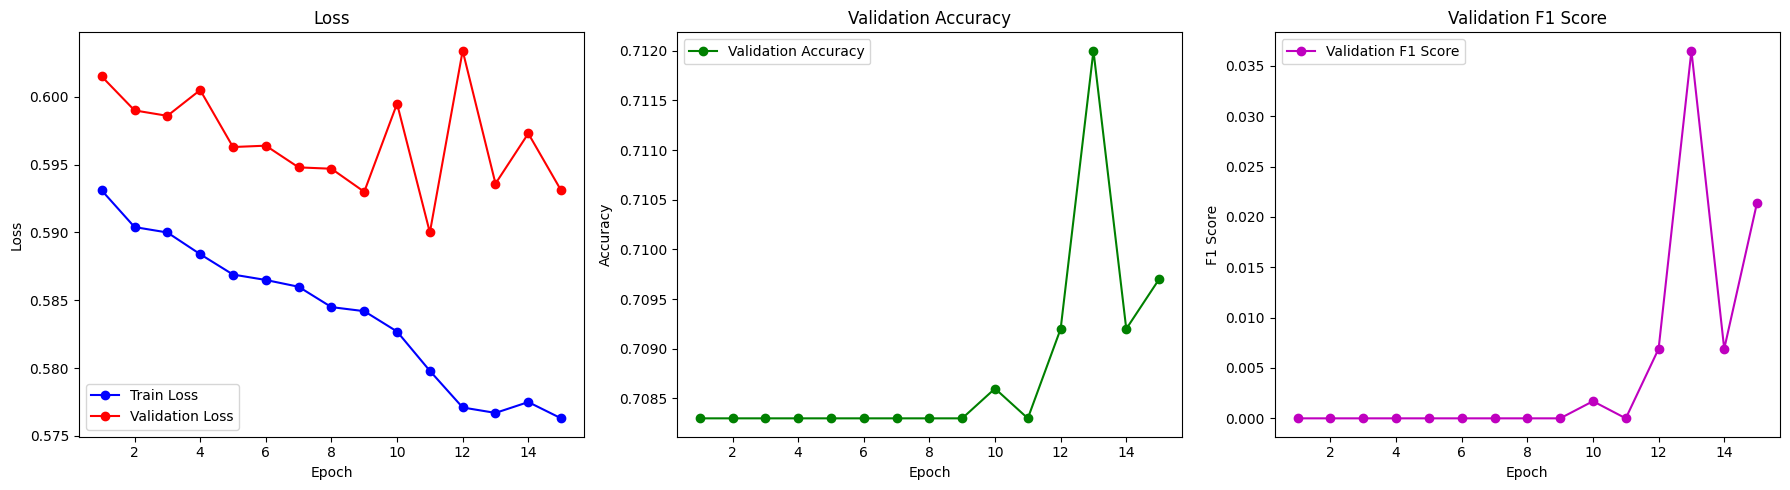

In [14]:
import matplotlib.pyplot as plt

# Dummy example data based on your logs:
train_losses = [
    0.5931, 0.5904, 0.5900, 0.5884, 0.5869, 0.5865, 0.5860, 0.5845, 0.5842, 0.5827,
    0.5798, 0.5771, 0.5767, 0.5775, 0.5763
]

val_losses = [
    0.6015, 0.5990, 0.5986, 0.6005, 0.5963, 0.5964, 0.5948, 0.5947, 0.5930, 0.5995,
    0.5900, 0.6034, 0.5936, 0.5973, 0.5931
]

val_accs = [
    0.7083, 0.7083, 0.7083, 0.7083, 0.7083, 0.7083, 0.7083, 0.7083, 0.7083, 0.7086,
    0.7083, 0.7092, 0.7120, 0.7092, 0.7097
]

val_f1s = [
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0017,
    0.0, 0.0069, 0.0365, 0.0069, 0.0214
]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accs, 'go-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot F1 Score
plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, 'mo-', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()
